In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
data_dir='/scratch/gpfs/jabbate/full_data'

with open(os.path.join(data_dir,'final_data.pkl'), 'rb') as f:
    data=pickle.load(f)

In [3]:
quartiles={}
for sig in ['thomson_temp_EFITRT1','thomson_dens_EFITRT1','ffprime_EFITRT1']:
    quartiles[sig]={}
    data_concat=[]
    for shot in data.keys():
        try:
            data_concat.extend(data[shot][sig])
        except:
            pass
    data_concat=np.array(data_concat)
    #data_concat=np.concatenate([data[shot][sig] for shot in data.keys()])
    quartiles[sig]['lower'] = np.nanpercentile(data_concat, 25, axis=0)
    quartiles[sig]['upper'] = np.nanpercentile(data_concat, 75, axis=0)

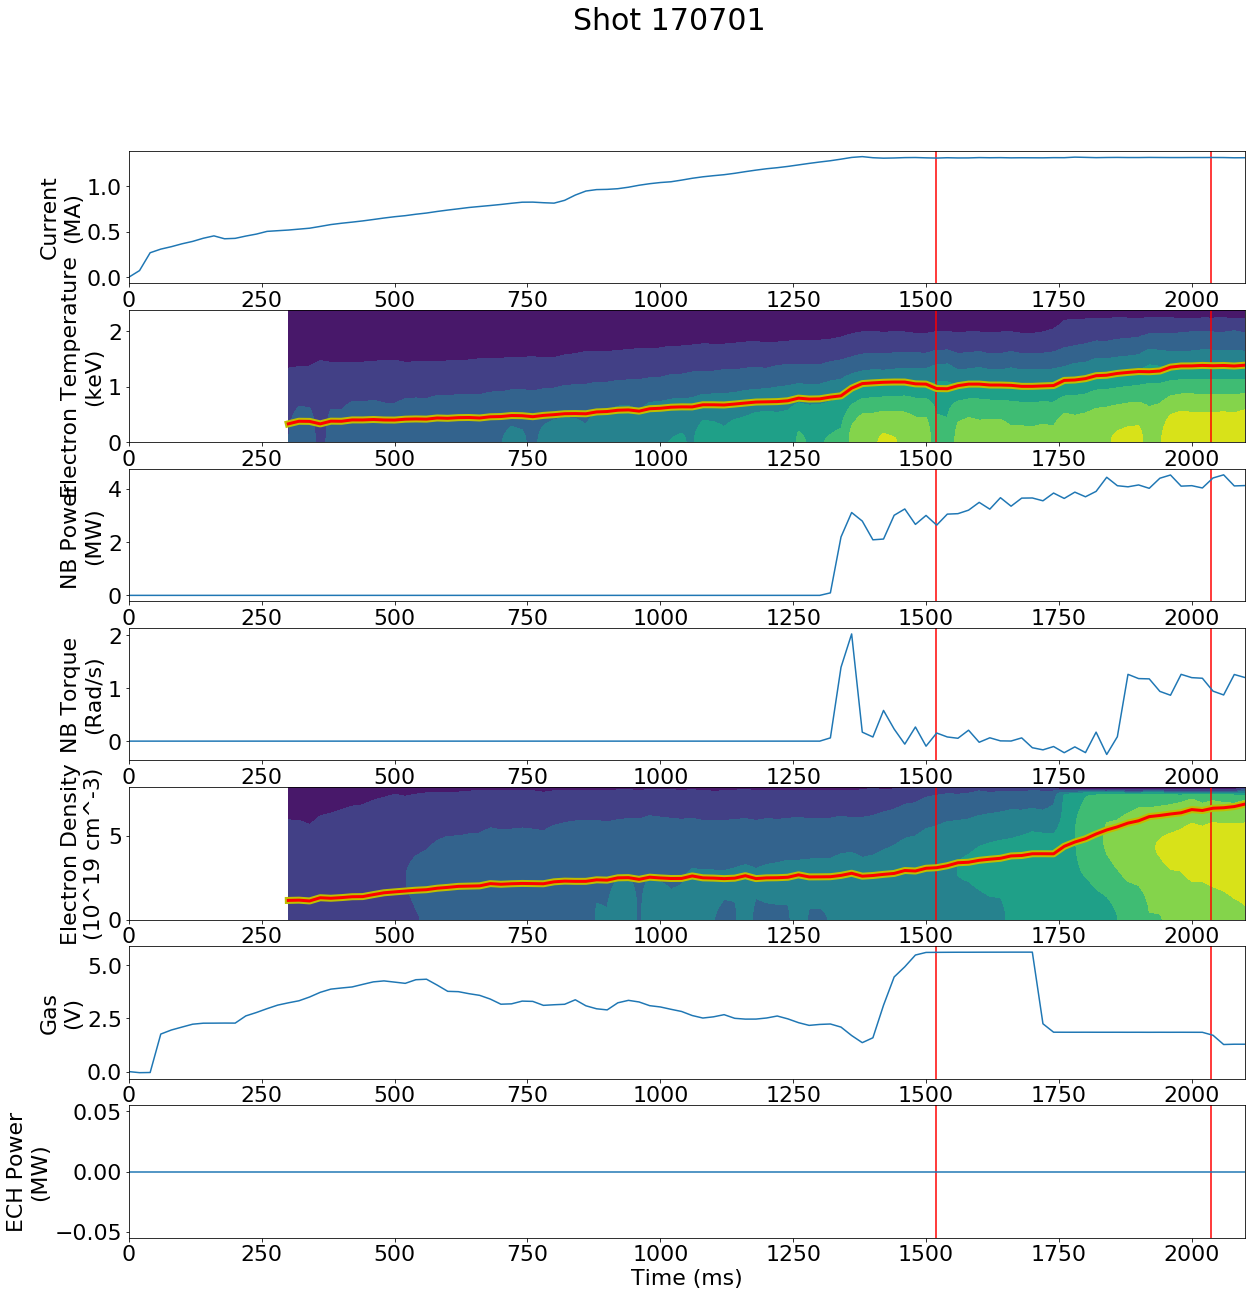

In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['font.size'] = 22

import numpy as np
import matplotlib.pyplot as plt

shots=list(data.keys())
shot=170701 #np.random.choice(shots)
sigs=['curr','temp','pinj','tinj','dens','gasA','ech'] #['ffprime_EFITRT1','curr_target','pinj','temp','dens','gas_feedback','target_density','gasA','gasA_voltage', 'beam_feedback_switch', 'beam_feedback_power_target_quantity', 'realtime_betan']
sig_names={'curr': 'Current\n(MA)',
           'temp':'Electron Temperature\n(keV)', 
           'dens': 'Electron Density\n(10^19 cm^-3)',
           'itemp':'Ion Temperature\n(keV)', 
           'pinj': 'NB Power\n(MW)', 
           'gasA': 'Gas\n(V)',
           'ech': 'ECH Power\n(MW)',
           'tinj': 'NB Torque\n(Rad/s)'}
conversion_factor={'temp': 1000,
                  'dens':1e19,
                  'pinj': 1000,
                  'tinj': 1,
                  'curr': 1e6,
                  'gasA': 1,
                  'ech': 1}

#sigs=['curr_target','pinj','temp','dens','target_source_pinj_30L','beam_feedback_switch','beam_feedback_switch','beam_feedback_power_target_quantity','beam_feedback_power_target_value','realtime_betan']
assert(all(data[shot]['gas_density_or_profile_algorithm']==0))

def removeOutliers(x, outlierConstant, sig):
    #upper_quartile = np.nanpercentile(x, 75)
    #lower_quartile = np.nanpercentile(x, 25)
    upper_quartile=quartiles[sig]['upper']
    lower_quartile=quartiles[sig]['lower']
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    return np.clip(x,lower_quartile - IQR,upper_quartile + IQR)


def my_normalize(arr):
    return (arr-np.nanmin(arr))/(np.nanmax(arr)-np.nanmin(arr))

fig=plt.figure()
for i,sig in enumerate(sigs):
    ax=fig.add_subplot(len(sigs),1.5,i+1)
    ax.axvline(data[shot]['t_ip_flat'],c='r')
    ax.axvline(data[shot]['t_ip_flat']+data[shot]['ip_flat_duration'],c='r')
    if sig in ['temp','dens']: #len(data[shot][sig].shape)>1:
        #thomson_sig_name='thomson_{}_EFITRT1'.format(sig)
        #thomson_sig=data[shot][thomson_sig_name]
        #thomson_sig=removeOutliers(thomson_sig,1.5,thomson_sig_name)
        #ax.plot(data[shot]['time'],my_normalize(data[shot]['pinj']),c='r')
            
        zipfit_sig=np.mean(data[shot][sig],axis=1) #my_normalize(np.mean(data[shot][sig],axis=1))
        
        ax.contourf(data[shot]['time'],
            np.linspace(0,np.nanmax(data[shot][sig]),65),
            #thomson_sig.T)
            data[shot][sig].T)
        
        ax.plot(data[shot]['time'],zipfit_sig,c='y',linewidth=7)
        ax.plot(data[shot]['time'],zipfit_sig,c='r',linewidth=3,label='Fitted')
        
        #thomson_sig=np.mean(thomson_sig,axis=1)/conversion_factor[sig] #my_normalize(np.mean(thomson_sig,axis=1))
        #ax.plot(data[shot]['time'],thomson_sig,c='b',linewidth=7,label='Raw Thomson')
        #ax.legend()
        #ax.plot(data[shot]['time'],my_normalize(np.mean(data[shot]['thomson_{}_EFITRT1'.format(sig)],axis=1), clip=True, sig=sig),c='g',linewidth=3)
    elif len(data[shot][sig].shape)>1:
        thomson_sig=removeOutliers(data[shot][sig],1.5,sig)
        
        ax.contourf(data[shot]['time'],
                    np.linspace(0,1,65),
                    #thomson_sig.T)
                    data[shot][sig].T)
            
#         zipfit_sig=my_normalize(np.mean(data[shot][sig],axis=1))
#         ax.plot(data[shot]['time'],zipfit_sig,c='y',linewidth=7)
#         ax.plot(data[shot]['time'],zipfit_sig,c='r',linewidth=3)
        
       
    elif sig=='target_density':
        ax.plot(data[shot]['time'],data[shot]['density_estimate'])
        ax.plot(data[shot]['time'],data[shot]['target_density'],c='r')
    elif sig=='realtime_betan':
        ax.plot(data[shot]['time'],data[shot]['realtime_betan'])
        ax.plot(data[shot]['time'],data[shot]['beam_feedback_power_target_value'],c='r')
    elif sig=='curr_target':
        ax.plot(data[shot]['time'],data[shot]['curr'])
        ax.plot(data[shot]['time'],data[shot]['curr_target'],c='r')
        
    else:
        ax.plot(data[shot]['time'],data[shot][sig]/conversion_factor[sig])
    ax.set_ylabel(sig_names[sig])
    ax.set_xlim(min(data[shot]['time']),max(data[shot]['time']))
    #ax.axvline(2220)
    #ax.axvline(2270)
plt.xlabel('Time (ms)')
#plt.subplots_adjust(hspace=.5)
fig.suptitle('Shot {}'.format(shot),fontsize=30)
plt.show()

In [148]:
shot=160358

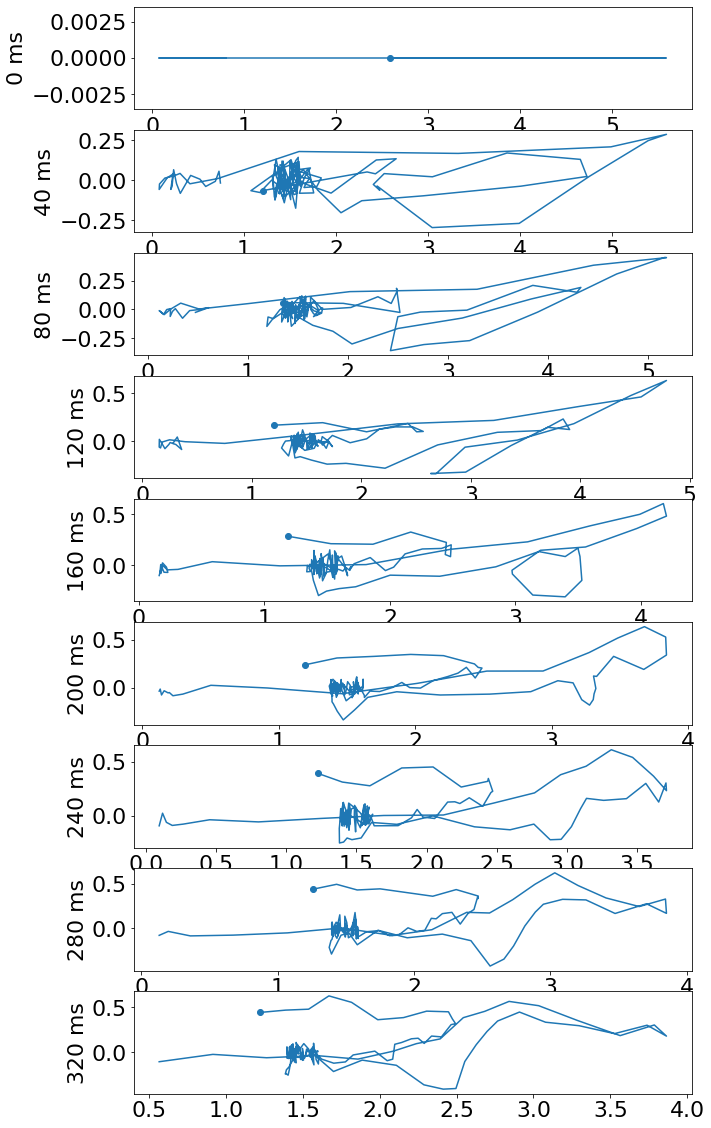

In [114]:
plt.rcParams['figure.figsize'] = [10, 20]
flat_start_time=data[shot]['t_ip_flat']
flat_end_time=data[shot]['ip_flat_duration']
time_start=np.searchsorted(data[shot]['time'],flat_start_time)
time_end=np.searchsorted(data[shot]['time'],data[shot]['t_ip_flat']+flat_end_time)

fig=plt.figure()
offsets=[0,2,4,6,8,10,12,14,16]

dep_sig='gasA'
ind_sig='dens'

for i,offset in enumerate(offsets):
    grand_offset=offset
    independent=data[shot][dep_sig][time_start-grand_offset:time_end-grand_offset]
    #dependent=np.mean(data[shot][ind_sig][time_start:time_end],axis=1)
    dependent=np.mean(data[shot][ind_sig][time_start:time_end],axis=1)-np.mean(data[shot][ind_sig][time_start-offset:time_end-offset],axis=1)
    if offset>0:
        independent=np.convolve(independent, np.ones((offset,))/offset, mode='same')
    ax=fig.add_subplot(len(offsets),1,i+1)
    ax.plot(independent,
            dependent)
    ax.set_ylabel('{} ms'.format(offset*20))
    ax.scatter(independent[0],dependent[0])
plt.show()

In [73]:
np.nanmax(thomson_sig)

4.789290029702825

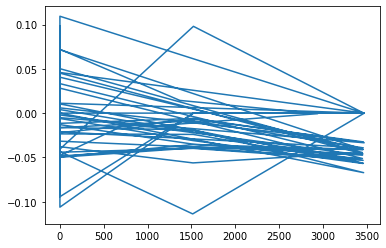

In [37]:
plt.rcParams['figure.figsize'] = [10, 10]
%matplotlib inline
offset=2
plt.plot(data[shot]['pinj'][:-(offset+1)],np.diff(np.mean(data[shot]['temp'],axis=1))[offset:])
plt.show()

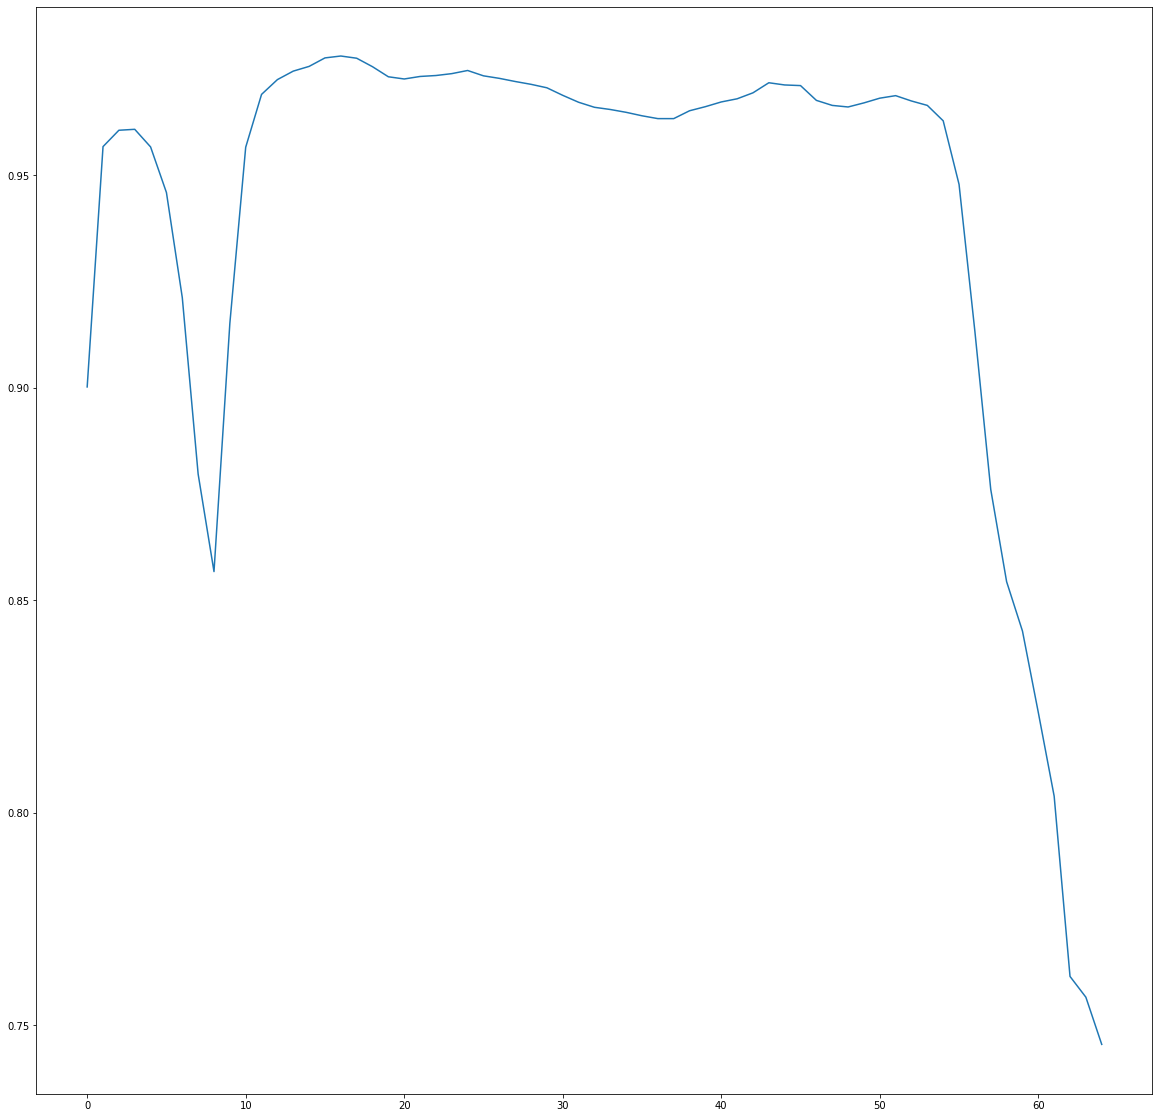

In [146]:
sig='thomson_temp_EFITRT1'
concat_data=np.concatenate([data[shot][sig] for shot in data.keys()])

lower_quartile=np.nanpercentile(concat_data,25,axis=0)
upper_quartile=np.nanpercentile(concat_data,75,axis=0)
IQR=(upper_quartile-lower_quartile)*.5

total_lower_quartile=np.nanpercentile(concat_data,25)
total_upper_quartile=np.nanpercentile(concat_data,75)
total_IQR=(total_upper_quartile-total_lower_quartile)*1.5

percentage_here=[]
for which_psi in range(0,65):
    lower_requirement=concat_data[:,which_psi]>=lower_quartile[which_psi] - IQR[which_psi] 
    upper_requirement=concat_data[:,which_psi]<=upper_quartile[which_psi] + IQR[which_psi] 
    #lower_requirement=concat_data[:,which_psi]>=total_lower_quartile - total_IQR
    #upper_requirement=concat_data[:,which_psi]<=total_upper_quartile + total_IQR
    percentage_here.append(sum(np.logical_and(lower_requirement, upper_requirement))/len(concat_data[:,which_psi]))
plt.plot(percentage_here)
plt.show()

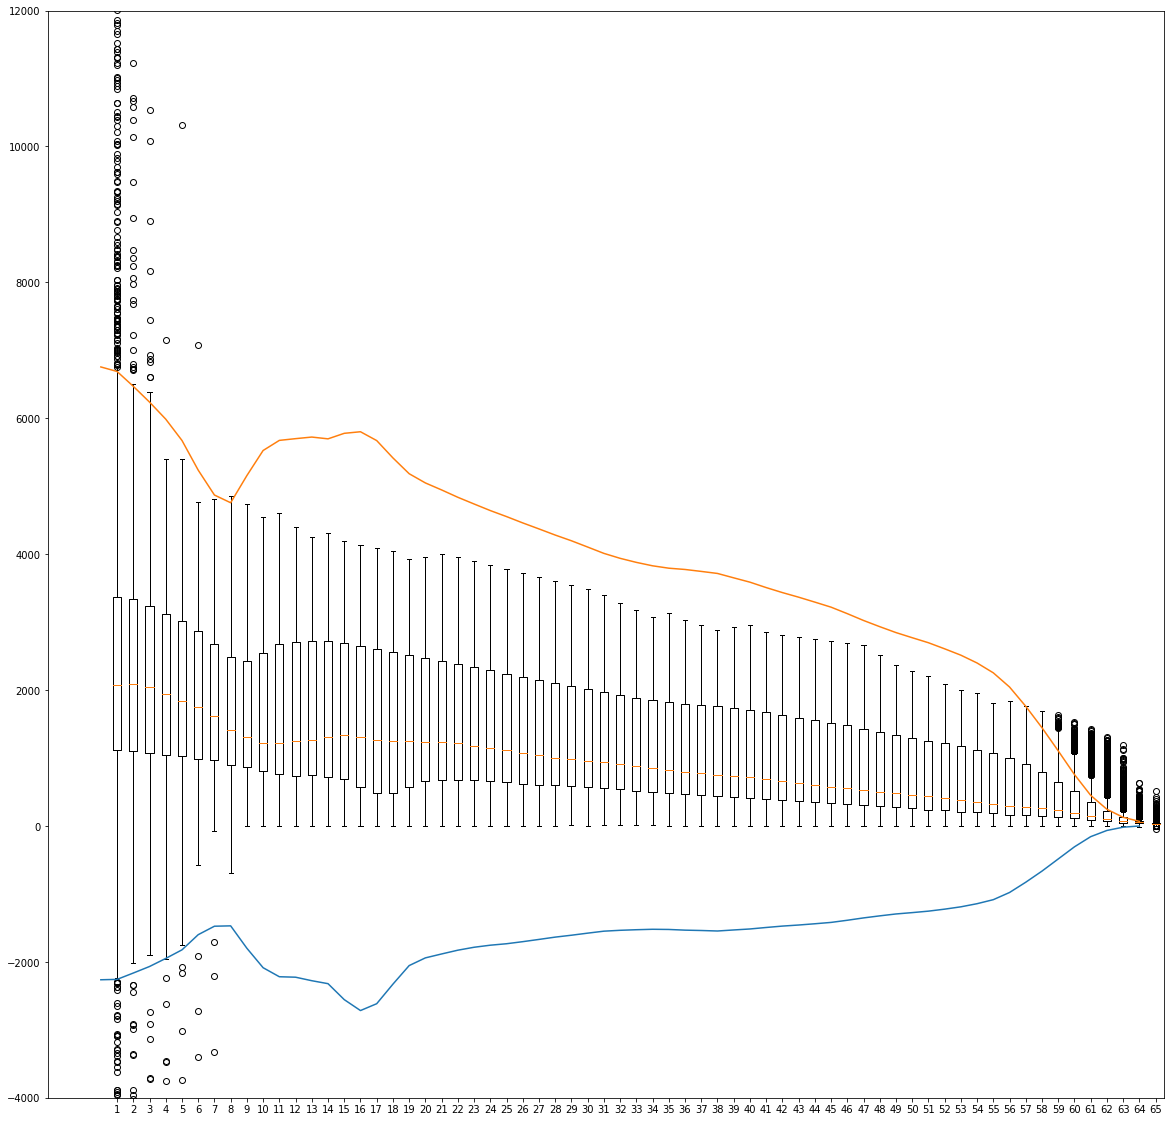

In [171]:
lower_quartile=np.nanpercentile(concat_data,25,axis=0)
upper_quartile=np.nanpercentile(concat_data,75,axis=0)
IQR=(upper_quartile-lower_quartile)*1.5

total_lower_quartile=np.nanpercentile(concat_data,25)
total_upper_quartile=np.nanpercentile(concat_data,75)
total_IQR=(total_upper_quartile-total_lower_quartile)*1.5

plt.boxplot([concat_data[~np.isnan(concat_data[:,which_psi])][:,which_psi] for which_psi in range(65)])
plt.ylim(-4000,12000)

plt.plot(lower_quartile-IQR)
plt.plot(upper_quartile+IQR)

# plt.axhline(total_lower_quartile-total_IQR)
# plt.axhline(total_upper_quartile+total_IQR)

plt.show()

## Gas feedback analysis

In [190]:
arr=[]
for shot in data.keys():
    this_entry=data[shot]
    if any(this_entry['gas_feedback']==1):
        arr.append(shot)

In [191]:
print(len(arr))
print(len(data.keys()))

50
50


In [36]:
a=np.array([[1,500,3],[200,1,1],[2,2,3],[1,2,3],[1,2,2],[1,1,1]])
# print(a)
# upper_quartiles = np.nanpercentile(a, 75, axis=0)
# lower_quartiles = np.nanpercentile(a, 75, axis=0)
# print(lower_quartiles)
# print(upper_quartiles)
print(a)
print(np.clip(a,[1,2,3],[2,3,4]))

[[  1 500   3]
 [200   1   1]
 [  2   2   3]
 [  1   2   3]
 [  1   2   2]
 [  1   1   1]]
[[1 3 3]
 [2 2 3]
 [2 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]


## Beam feedback analysis

In [192]:
arr=[]

beams=['15L','15R','21L','21R','30L','30R','33L','33R']
for shot in data.keys():
    this_entry=data[shot]
    if all([any(this_entry['target_source_pinj_{}'.format(beam)]==0) for beam in beams]):
        arr.append(shot)

In [193]:
print(len(arr))
print(len(data.keys()))

50
50
